# Gemma-3-1B Fine-Tuning: QLoRA vs GaLore Comparison

Bu notebook Gemma-3-1b-it modelini QLoRA ve GaLore teknikleri ile fine-tune eder ve karşılaştırır.

**Gereksinimler:**
- Colab Pro (GPU ve high RAM)
- HuggingFace token (Gemma model erişimi için)

**Runtime Ayarları:**
- Runtime > Change runtime type > GPU (T4 veya A100)

## 1. Setup - GitHub Clone ve Dependencies

In [1]:
# GitHub repository clone
import os

if not os.path.exists('/content/Gemma-Finetune'):
    print("Repository clone ediliyor")
    !git clone https://github.com/sendayildirim/Gemma-Finetune
    print("Clone tamamlandi")
else:
    print("Repository zaten mevcut")

# Working directory
os.chdir('/content/Gemma-Finetune')
print(f"Working directory: {os.getcwd()}")



import sys
sys.path.insert(0, '/content/Gemma-Finetune')

!pip install -q -r requirements.txt

print("Dependencies yuklendi")

Repository clone ediliyor
Cloning into 'Gemma-Finetune'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 232 (delta 113), reused 197 (delta 93), pack-reused 0 (from 0)
Receiving objects: 100% (232/232), 260.98 KiB | 3.53 MiB/s, done.
Resolving deltas: 100% (113/113), done.
Clone tamamlandi
Working directory: /content/Gemma-Finetune
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.0 MB/s eta 0:00:00
Dependencies yuklendi


In [2]:
import sys
import torch
import transformers
import datasets
import peft
import trl
import accelerate
import os
import random
import numpy as np
import pandas as pd
from huggingface_hub import login
import json
import gc

login(new_session=False)

os.environ["WANDB_DISABLED"] = "true"

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 39.56 GB


## 1.5 Reproducibility - Seed Initialization

Tüm random işlemlerin reproducible olması için seed=42 kullanılır.

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

## 2. Dataset Hazirlama ve Onizleme

In [4]:
from src.data.prepare_datasets import DatasetPreparer
from src.config.data_config import get_data_config

config = get_data_config()
preparer = DatasetPreparer(config)

print("Dataset preparer hazir")

Dataset preparer hazir


In [5]:
print("Dataset'ler indiriliyor ve sample'lar aliniyor")

train_dataset, test_dataset = preparer.prepare_all_datasets()

print(f"\nToplam train samples: {len(train_dataset)}")
print(f"Toplam test samples: {len(test_dataset)}")

Dataset'ler indiriliyor ve sample'lar aliniyor
Dataset'ler yukleniyor
Alpaca yukleniyor


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

Alpaca yuklendi: 52002 ornek
Tulu v2 yukleniyor


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003-99ee8754042a69(…):   0%|          | 0.00/97.1M [00:00<?, ?B/s]

data/train-00001-of-00003-278198836de599(…):   0%|          | 0.00/239M [00:00<?, ?B/s]

data/train-00002-of-00003-a52de323599d58(…):   0%|          | 0.00/219M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/326154 [00:00<?, ? examples/s]

Tulu v2 yuklendi: 326154 ornek
Ultrachat 200k yukleniyor


README.md: 0.00B [00:00, ?B/s]

data/train_sft-00000-of-00003-a3ecf92756(…):   0%|          | 0.00/244M [00:00<?, ?B/s]

data/train_sft-00001-of-00003-0a1804bcb6(…):   0%|          | 0.00/244M [00:00<?, ?B/s]

data/train_sft-00002-of-00003-ee46ed25cf(…):   0%|          | 0.00/244M [00:00<?, ?B/s]

data/test_sft-00000-of-00001-f7dfac4afe5(…):   0%|          | 0.00/81.2M [00:00<?, ?B/s]

data/train_gen-00000-of-00003-a6c9fb894b(…):   0%|          | 0.00/244M [00:00<?, ?B/s]

data/train_gen-00001-of-00003-d6a0402e41(…):   0%|          | 0.00/243M [00:00<?, ?B/s]

data/train_gen-00002-of-00003-c0db75b92a(…):   0%|          | 0.00/243M [00:00<?, ?B/s]

data/test_gen-00000-of-00001-3d4cd830914(…):   0%|          | 0.00/80.4M [00:00<?, ?B/s]

Generating train_sft split:   0%|          | 0/207865 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/23110 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/256032 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/28304 [00:00<?, ? examples/s]

Ultrachat yuklendi: 207865 ornek

alpaca icin sampling yapiliyor


Flattening the indices:   0%|          | 0/5200 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/2100 [00:00<?, ? examples/s]

alpaca formatlaniyor


Formatting alpaca train:   0%|          | 0/5200 [00:00<?, ? examples/s]

Formatting alpaca test:   0%|          | 0/2100 [00:00<?, ? examples/s]

alpaca - Train: 5200, Test: 2100

tulu icin sampling yapiliyor


Flattening the indices:   0%|          | 0/5200 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/2100 [00:00<?, ? examples/s]

tulu formatlaniyor


Formatting tulu train:   0%|          | 0/5200 [00:00<?, ? examples/s]

Formatting tulu test:   0%|          | 0/2100 [00:00<?, ? examples/s]

tulu - Train: 5200, Test: 2100

ultrachat icin sampling yapiliyor


Flattening the indices:   0%|          | 0/5200 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/2100 [00:00<?, ? examples/s]

ultrachat formatlaniyor


Formatting ultrachat train:   0%|          | 0/5200 [00:00<?, ? examples/s]

Formatting ultrachat test:   0%|          | 0/2100 [00:00<?, ? examples/s]

ultrachat - Train: 5200, Test: 2100

Dataset'ler birlestiriliyor

Dataset schema kontrolu (formatlama sonrasi):

alpaca:
  Features: {'source_dataset': Value('string'), 'messages': List({'content': Value('string'), 'role': Value('string')})}
  Ilk sample keys: ['source_dataset', 'messages']
  Messages type: <class 'list'>
  First message keys: ['content', 'role']
  Number of messages: 2

tulu:
  Features: {'messages': List({'role': Value('string'), 'content': Value('string')}), 'source_dataset': Value('string')}
  Ilk sample keys: ['messages', 'source_dataset']
  Messages type: <class 'list'>
  First message keys: ['role', 'content']
  Number of messages: 2

ultrachat:
  Features: {'messages': List({'content': Value('string'), 'role': Value('string')}), 'source_dataset': Value('string')}
  Ilk sample keys: ['messages', 'source_dataset']
  Messages type: <class 'list'>
  First message keys: ['content', 'role']
  Number of messages: 8

Dataset'leri dict formatina cevirip birlestiriyor

T

In [6]:
preparer.save_datasets(train_dataset, test_dataset)
print("Dataset'ler kaydedildi")


Dataset'ler kaydediliyor
Train: ./data/samples/train_samples.json
Test: ./data/samples/test_samples.json


Creating json from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Istatistikler: ./data/samples/dataset_stats.json
Kayit tamamlandi
Dataset'ler kaydedildi


In [7]:
for source in ["alpaca", "tulu", "ultrachat"]:
    source_samples = train_dataset.filter(lambda x: x["source_dataset"] == source)

    print(f"{source.upper()} Dataset Örnek")

    if len(source_samples) > 0:
        sample = source_samples[0]
        for key, value in sample.items():
            if isinstance(value, str) and len(value) > 200:
                print(f"{key}: {value[:200]}")
            else:
                print(f"{key}: {value}")
    print()

Filter:   0%|          | 0/15600 [00:00<?, ? examples/s]

ALPACA Dataset Örnek
messages: [{'content': 'Create a list of reasons why having a pet can be beneficial.', 'role': 'user'}, {'content': 'Having a pet can be beneficial for many reasons such as:\n\n1. Pets provide companionship, reducing loneliness and depression. \n2. Having a pet can help lower stress levels and reduce anxiety. \n3. Caring for a pet can help improve people’s overall sense of wellbeing. \n4. Pets can provide a purpose and help give structure and routine to people’s lives. \n5. Playing and talking to pets can help improve communication skills. \n6. Pets are a great way for people to receive unconditional love, something that can be hard to find. \n7. Pets can help enhance feelings of self-worth due to the responsibility and trust that comes with pet ownership. \n8. Pets can provide much needed exercise and outdoor activity. \n9. Pets offer entertainment and fun, often providing delightful surprises that can lift people’s moods.', 'role': 'assistant'}]
source_dataset: a

Filter:   0%|          | 0/15600 [00:00<?, ? examples/s]

TULU Dataset Örnek
messages: [{'content': 'more functions', 'role': 'user'}, {'content': "Here are some additional functions that you can add to the chart:\n\n* Add a hovertext that displays the date and price of the candlestick when the user hovers over it. You can do this by setting the `text` parameter of the `go.Candlestick` object to a list of strings that contain the desired hovertext.\n* Add a second y-axis that displays the volume of the stock. You can do this by setting the `secondary_y` parameter of the `go.Candlestick` object to `True`, and then adding a `go.Bar` trace to the chart that displays the volume data on the secondary y-axis.\n* Add a legend that displays the name of the stock. You can do this by setting the `showlegend` parameter of the `layout` object to `True`, and then setting the `name` parameter of the `go.Candlestick` object to the name of the stock.\n* Add a title to the chart. You can do this by setting the `title` parameter of the `layout` object to the d

Filter:   0%|          | 0/15600 [00:00<?, ? examples/s]

ULTRACHAT Dataset Örnek
messages: [{'content': "Obesity is an adipose belief of yourself as a substance.\nFood does not exist, except in material falsehood, a vision created by “mortal mind.” The lowly bowl of mashed potatoes set on the table is an idea of eternal thought, no more real than the tuber in the ground, the soil being an illusion itself. And of this imaginary realm is butter, melted in a yellow puddle in the middle of the mound, conjured from the cow.\nThe cow is an aspect of Divine Intelligence, its milk an expression of liquid, an interpretation of water from which the concept of cream pours forth. The idea of fat arises, and then the notion that this can be churned. Voila, the semblance of butter appears in the pantry. Butter has no calories. The calorie is an erroneous concept which only exists in school books.\nButter slathered in great quantities on food, all of which is imagined, can be eaten or not eaten to no effect. Fat passes as nothing through the temple of the 

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

source_counts = {}
for sample in train_dataset:
    source = sample["source_dataset"]
    source_counts[source] = source_counts.get(source, 0) + 1

print("Dataset dagilimlari:")
for source, count in source_counts.items():
    print(f"  {source}: {count} samples")

Dataset dagilimlari:
  alpaca: 5200 samples
  ultrachat: 5200 samples
  tulu: 5200 samples


## 3. Preprocessing - Gemma Chat Template

In [9]:
from src.data.preprocess import DatasetPreprocessor

preprocessor = DatasetPreprocessor(config)

print("Preprocessor hazir")
print(f"Tokenizer: {preprocessor.tokenizer.name_or_path}");

Tokenizer yukleniyor


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Tokenizer yuklendi
Preprocessor hazir
Tokenizer: google/gemma-3-1b-it


In [10]:
print("Dataset'ler Gemma chat template'ine cevriliyor")

train_processed, test_processed = preprocessor.load_and_preprocess()

Dataset'ler Gemma chat template'ine cevriliyor
Sample'lar yukleniyor


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train sample'lari: 15600
Test sample'lari: 6300

Preprocessing basliyor


Preprocessing:   0%|          | 0/15600 [00:00<?, ? examples/s]

Chat template hatasi: Conversation roles must alternate user/assistant/user/assistant/...
Chat template hatasi: Conversation roles must alternate user/assistant/user/assistant/...
Chat template hatasi: Conversation roles must alternate user/assistant/user/assistant/...
Chat template hatasi: Conversation roles must alternate user/assistant/user/assistant/...
Chat template hatasi: Conversation roles must alternate user/assistant/user/assistant/...


Filter:   0%|          | 0/15600 [00:00<?, ? examples/s]

Preprocessing:   0%|          | 0/6300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6300 [00:00<?, ? examples/s]


Preprocessed train sample'lari: 15595
Preprocessed test sample'lari: 6300

Balancing datasets...


Filter:   0%|          | 0/15595 [00:00<?, ? examples/s]

alpaca (train): 5200 available, need 5000


Filter:   0%|          | 0/15595 [00:00<?, ? examples/s]

tulu (train): 5196 available, need 5000


Filter:   0%|          | 0/15595 [00:00<?, ? examples/s]

ultrachat (train): 5199 available, need 5000


Filter:   0%|          | 0/6300 [00:00<?, ? examples/s]

alpaca (test): 2100 available, need 2000


Filter:   0%|          | 0/6300 [00:00<?, ? examples/s]

tulu (test): 2100 available, need 2000


Filter:   0%|          | 0/6300 [00:00<?, ? examples/s]

ultrachat (test): 2100 available, need 2000

Final balanced train samples: 15000
Final balanced test samples: 6000


In [11]:
print("PREPROCESSED ORNEK (Gemma Chat Format)")
print(train_processed[0]["text"])

PREPROCESSED ORNEK (Gemma Chat Format)
<bos><start_of_turn>user
Design a comprehensive training program that covers sales management techniques, customer relationship building, and team leadership skills for new sales managers in your organization. The program should include a mix of classroom instruction, interactive exercises, and on-the-job training to ensure that new managers are equipped to succeed in their roles. Additionally, consider incorporating case studies and role-playing exercises to allow new managers to apply their knowledge in realistic scenarios.<end_of_turn>
<start_of_turn>model
The following is a comprehensive training program that covers sales management techniques, customer relationship building, and team leadership skills for new sales managers in your organization:

1. Classroom Instruction:

a) Sales Management Techniques:
  - Overview of sales management
  - Setting sales goals and objectives
  - Sales forecasting and budgeting
  - Managing the sales process a

In [12]:
preprocessor.save_processed_datasets(train_processed, test_processed)

print("Preprocessed dataset'ler kaydedildi")


Processed dataset'ler kaydediliyor
Train: ./data/processed/train_processed.json
Test: ./data/processed/test_processed.json


Creating json from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Filter:   0%|          | 0/15000 [00:00<?, ? examples/s]

alpaca ornegi: ./data/processed/examples/alpaca_example.txt


Filter:   0%|          | 0/15000 [00:00<?, ? examples/s]

tulu ornegi: ./data/processed/examples/tulu_example.txt


Filter:   0%|          | 0/15000 [00:00<?, ? examples/s]

ultrachat ornegi: ./data/processed/examples/ultrachat_example.txt
Kayit tamamlandi
Preprocessed dataset'ler kaydedildi


In [13]:
print("GEMMA CHAT TEMPLATE FORMAT ORNEKLERI")

examples_dir = "./data/processed/examples"

for source in ["alpaca", "tulu", "ultrachat"]:
    example_file = os.path.join(examples_dir, f"{source}_example.txt")

    if os.path.exists(example_file):
        print(f"{source.upper()} Dataset - Gemma Format:")

        with open(example_file, "r", encoding="utf-8") as f:
            content = f.read()
            if len(content) > 600:
                print(content[:600] + "\n...")
            else:
                print(content)
    else:
        print(f"{source} example dosyasi bulunamadi")

GEMMA CHAT TEMPLATE FORMAT ORNEKLERI
ALPACA Dataset - Gemma Format:
<bos><start_of_turn>user
Transform a statement provided into a rhetorical statement.

Input: John is too busy to hang out with us.<end_of_turn>
<start_of_turn>model
Why is John too busy to hang out with us?<end_of_turn>

TULU Dataset - Gemma Format:
<bos><start_of_turn>user
Can you help with this?

Define a constructor in Java to create an instance of a class.<end_of_turn>
<start_of_turn>model
public class MyClass {
    // Constructors
    public MyClass() {
        // Default constructor
    }
    
    // Constructor with parameters
    public MyClass(int a, int b) {
        // Do something with the parameters
    }
 }<end_of_turn>

ULTRACHAT Dataset - Gemma Format:
<bos><start_of_turn>user
Design a comprehensive training program that covers sales management techniques, customer relationship building, and team leadership skills for new sales managers in your organization. The program should include a mix of classroom 

## 4. Base Model Evaluation (Baseline)

In [29]:
from src.evaluation.evaluate_base import BaseModelEvaluator

base_evaluator = BaseModelEvaluator(model_name=config.model_name)

print("Base model evaluator hazir")

Base model evaluator hazir


In [30]:
import importlib
if 'src.evaluation.evaluate_base' in sys.modules:
    del sys.modules['src.evaluation.evaluate_base']
    from src.evaluation.evaluate_base import BaseModelEvaluator
    base_evaluator = BaseModelEvaluator(model_name=config.model_name)
    print("Module reloaded - batch processing aktif!")

print("Base model yukleniyor")
base_evaluator.load_model()

print("Model yuklendi")

Module reloaded - batch processing aktif!
Base model yukleniyor
Base model yukleniyor: google/gemma-3-1b-it
Model yuklendi
Model yuklendi


In [32]:
import time
print("Base model evaluation basliyor")
print( "Burada GPU RAM 2.6'dan 26.1'e çıktı")

test_dataset_path = "./data/processed/test_processed.json"
start_time = time.time()
base_results = base_evaluator.evaluate_on_test_set(
    test_dataset_path,
    max_samples=500
)
elapsed_time = time.time() - start_time
elapsed_minutes = elapsed_time / 60
print("Base Model Results:")
print(f"BLEU-4: {base_results['bleu_4']:.4f}")
print(f"ROUGE-L: {base_results['rouge_l']:.4f}")
print(f"Evaluation completed in {elapsed_minutes:.2f} minutes")

Base model evaluation basliyor
Burada GPU RAM 2.6'dan 26.1'e çıktı

Test dataset yukleniyor
Test dataset boyutu: 500

Instructions extract ediliyor
Toplam 500 valid sample bulundu

Batch generation basliyor (batch_size=64)

Metrikler hesaplaniyor

Base Model Evaluation Results
BLEU-4: 0.0582
ROUGE-L: 0.1632
Evaluated samples: 500

Results kaydedildi: ./results/metrics/base_model_results.json
Examples kaydedildi: ./results/metrics/base_model_examples.json
Base Model Results:
BLEU-4: 0.0582
ROUGE-L: 0.1632
Evaluation completed in 2.47 minutes


In [33]:
with open('results/metrics/base_model_examples.json', 'r') as f:
    examples = json.load(f)

print("BASE MODEL ORNEK GENERATION'LAR:")

for i, ex in enumerate(examples[:3], 1):
    print(f"Ornek {i}:")
    print(f"Instruction: {ex['instruction'][:10000]}")
    print(f"Expected: {ex['expected'][:10000]}")
    print(f"Generated: {ex['generated'][:10000]}")

BASE MODEL ORNEK GENERATION'LAR:
Ornek 1:
Instruction: Can you tell me if there is any information on how much the recently fallen rock on El Capitan weighed?
Expected: There was no immediate estimate for how much the rock that fell in the most recent incident weighed, but park officials said that all of the rock falls that took place on Wednesday weighed a total of 1,300 tons (1,100 metric tons).
Generated: user
Can you tell me if there is any information on how much the recently fallen rock on El Capitan weighed?
model
Okay, let's dive into the fascinating and somewhat mysterious weight of El Capitan's fallen rock! It's a surprisingly complex and debated topic. Here's a breakdown of what we know, based on recent research and analysis:

**The Initial Estimates (and Why They Were So Large):**

* **Early Estimates (1990s):** In the 1990s, estimates ranged from 200 to 500 tons. This was largely based on the size of the rock fragments and the sheer volume of material that had fallen.
* **

In [34]:
del base_evaluator
gc.collect()
torch.cuda.empty_cache()
print("Memory temizlendi")

Memory temizlendi


## 4.5 Hyperparameter Configuration Comparison

Bu hücre QLoRA ve GaLore tekniklerinin hyperparameter'larını karşılaştırır.
Report için gerekli comparison table'ı oluşturur.

In [14]:
from src.config.qlora_config import get_qlora_config
from src.config.galore_config import get_galore_config

qlora_cfg = get_qlora_config()
galore_cfg = get_galore_config()

comparison_data = {
    'Hyperparameter': [
        'Epochs',
        'Batch Size (per device)',
        'Gradient Accumulation',
        'Effective Batch Size',
        'Learning Rate',
        'Weight Decay',
        'Warmup Steps',
        'Max Sequence Length',
        'Optimizer',
        'LR Scheduler',
        'Precision',
        'Gradient Checkpointing',
        'Max Grad Norm',
        'Random Seed'
    ],
    'QLoRA': [
        qlora_cfg.num_train_epochs,
        qlora_cfg.per_device_train_batch_size,
        qlora_cfg.gradient_accumulation_steps,
        qlora_cfg.per_device_train_batch_size * qlora_cfg.gradient_accumulation_steps,
        qlora_cfg.learning_rate,
        qlora_cfg.weight_decay,
        qlora_cfg.warmup_steps,
        qlora_cfg.max_seq_length,
        qlora_cfg.optim,
        qlora_cfg.lr_scheduler_type,
        'BF16' if qlora_cfg.bf16 else ('FP16' if qlora_cfg.fp16 else 'FP32'),
        'Yes' if qlora_cfg.gradient_checkpointing else 'No',
        qlora_cfg.max_grad_norm,
        qlora_cfg.seed
    ],
    'GaLore': [
        galore_cfg.num_train_epochs,
        galore_cfg.per_device_train_batch_size,
        galore_cfg.gradient_accumulation_steps,
        galore_cfg.per_device_train_batch_size * galore_cfg.gradient_accumulation_steps,
        galore_cfg.learning_rate,
        galore_cfg.weight_decay,
        galore_cfg.warmup_steps,
        galore_cfg.max_seq_length,
        galore_cfg.optim,
        galore_cfg.lr_scheduler_type,
        'BF16' if galore_cfg.bf16 else ('FP16' if galore_cfg.fp16 else 'FP32'),
        'Yes' if galore_cfg.gradient_checkpointing else 'No',
        galore_cfg.max_grad_norm,
        galore_cfg.seed
    ],
    'Rationale': [
        'Sufficient for convergence',
        'Memory constraint',
        'Memory optimization',
        'Effective batch size',
        'Adjusted for technique',
        'Regularization',
        'Learning rate warmup',
        'Gemma context window',
        'Technique-specific',
        'Smooth decay',
        'Numerical stability',
        'Memory optimization',
        'Gradient clipping',
        'Reproducibility'
    ]
}

df = pd.DataFrame(comparison_data)

print("HYPERPARAMETER COMPARISON TABLE")
print(df.to_string(index=False))

print("TECHNIQUE-SPECIFIC PARAMETERS:")
print("QLoRA:")
print(f"  - LoRA rank (r): {qlora_cfg.lora_r}")
print(f"  - LoRA alpha: {qlora_cfg.lora_alpha}")
print(f"  - LoRA dropout: {qlora_cfg.lora_dropout}")
print(f"  - Target modules: {qlora_cfg.target_modules}")
print(f"  - 4-bit quantization: {qlora_cfg.load_in_4bit}")
print(f"  - Quantization type: {qlora_cfg.bnb_4bit_quant_type}")

print("GaLore:")
print(f"  - Rank: {galore_cfg.rank}")
print(f"  - Update projection gap: {galore_cfg.update_proj_gap}")
print(f"  - GaLore scale: {galore_cfg.galore_scale}")
print(f"  - Projection type: {galore_cfg.proj_type}")
print(f"  - Target modules: {galore_cfg.target_modules_list}")


os.makedirs('results/metrics', exist_ok=True)
df.to_csv('results/metrics/hyperparameter_comparison.csv', index=False)
print("Table saved to: results/metrics/hyperparameter_comparison.csv")

HYPERPARAMETER COMPARISON TABLE
         Hyperparameter            QLoRA       GaLore                  Rationale
                 Epochs                3            3 Sufficient for convergence
Batch Size (per device)                4            4          Memory constraint
  Gradient Accumulation                4            4        Memory optimization
   Effective Batch Size               16           16       Effective batch size
          Learning Rate           0.0002       0.0001     Adjusted for technique
           Weight Decay             0.01         0.01             Regularization
           Warmup Steps              100          100       Learning rate warmup
    Max Sequence Length             2048         2048       Gemma context window
              Optimizer paged_adamw_8bit galore_adamw         Technique-specific
           LR Scheduler           cosine       cosine               Smooth decay
              Precision             BF16         BF16        Numerical stabil

## 5. QLoRA Fine-Tuning

In [15]:
from src.config.qlora_config import get_qlora_config

qlora_config = get_qlora_config()

print("QLoRA Konfigurasyonu:")
print(f"  Model: {qlora_config.model_name}")
print(f"  LoRA rank: {qlora_config.lora_r}")
print(f"  LoRA alpha: {qlora_config.lora_alpha}")
print(f"  Learning rate: {qlora_config.learning_rate}")
print(f"  Epochs: {qlora_config.num_train_epochs}")
print(f"  Batch size: {qlora_config.per_device_train_batch_size}")

QLoRA Konfigurasyonu:
  Model: google/gemma-3-1b-it
  LoRA rank: 16
  LoRA alpha: 32
  Learning rate: 0.0002
  Epochs: 3
  Batch size: 4


In [16]:
from src.training.train_qlora import train

print("QLoRA TRAINING BASLIYOR")

train(qlora_config)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


QLoRA TRAINING BASLIYOR
QLoRA Fine-Tuning Basliyor

Device bilgileri:
  cuda_available: True
  cuda_device_count: 1
  cuda_device_name: NVIDIA A100-SXM4-40GB
  cuda_version: 12.6

GPU kullanimi:
GPU 0: NVIDIA A100-SXM4-40GB
  Memory Usage: 5.0MB / 40960.0MB (0.0%)
  GPU Load: 0.0%
Model ve tokenizer yukleniyor
Model: google/gemma-3-1b-it


config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Model yuklendi

Model yukleme sonrasi GPU memory: 1.46 GB

LoRA konfigurasyonu ayarlaniyor
LoRA konfigurasyonu tamamlandi
Trainable params: 13,045,760 || All params: 664,050,816 || Trainable%: 1.96%

Dataset yukleniyor: ./data/processed/train_processed.json


Generating train split: 0 examples [00:00, ? examples/s]

Dataset boyutu: 15000

Training arguments ayarlaniyor

SFTTrainer olusturuluyor


Adding EOS to train dataset:   0%|          | 0/15000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/15000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/15000 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.



Training Basliyor


Step,Training Loss
10,3.410200
20,2.849400
30,2.123500
40,1.815700
50,1.913300
60,1.687700
70,1.677800
80,1.651300
90,1.596000
100,1.596800


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using


Training Tamamlandi

Model kaydediliyor

Training Metrikleri
Training suresi: 2h 4m 50s
Peak GPU memory: 1.51 GB
Metrikler kaydedildi: ./results/metrics/qlora_metrics.json

QLoRA fine-tuning tamamlandi


In [17]:
with open('results/metrics/qlora_metrics.json', 'r') as f:
    qlora_metrics = json.load(f)

print("QLoRA Training Metrikleri:")
print(f"  Peak Memory: {qlora_metrics['memory_stats']['peak_memory_allocated_gb']:.2f} GB")
print(f"  Training Time: {qlora_metrics['training_time_hours']:.2f} hours")
print(f"  Config: {json.dumps(qlora_metrics['config'], indent=2)}")

QLoRA Training Metrikleri:
  Peak Memory: 1.51 GB
  Training Time: 2.08 hours
  Config: {
  "lora_r": 16,
  "lora_alpha": 32,
  "lora_dropout": 0.05,
  "learning_rate": 0.0002,
  "num_train_epochs": 3,
  "batch_size": 4,
  "gradient_accumulation_steps": 4
}


In [18]:
gc.collect()
torch.cuda.empty_cache()
print("Memory temizlendi")

Memory temizlendi


## 6. GaLore Fine-Tuning

In [19]:
from src.config.galore_config import get_galore_config

galore_config = get_galore_config()

print("GaLore Konfigurasyonu:")
print(f"  Model: {galore_config.model_name}")
print(f"  Rank: {galore_config.rank}")
print(f"  Update projection gap: {galore_config.update_proj_gap}")
print(f"  Learning rate: {galore_config.learning_rate}")
print(f"  Epochs: {galore_config.num_train_epochs}")
print(f"  Batch size: {galore_config.per_device_train_batch_size}")

GaLore Konfigurasyonu:
  Model: google/gemma-3-1b-it
  Rank: 128
  Update projection gap: 200
  Learning rate: 0.0001
  Epochs: 3
  Batch size: 4


In [20]:
from src.training.train_galore import train as train_galore

print("GALORE TRAINING BASLIYOR")

train_galore(galore_config)

GALORE TRAINING BASLIYOR
GaLore Fine-Tuning Basliyor

Device bilgileri:
  cuda_available: True
  cuda_device_count: 1
  cuda_device_name: NVIDIA A100-SXM4-40GB
  cuda_version: 12.6

GPU kullanimi:
GPU 0: NVIDIA A100-SXM4-40GB
  Memory Usage: 1667.0MB / 40960.0MB (4.1%)
  GPU Load: 0.0%
Model ve tokenizer yukleniyor
Model: google/gemma-3-1b-it
Model yuklendi
Trainable params: 999,885,952 || All params: 999,885,952 || Trainable%: 100.00%

Model yukleme sonrasi GPU memory: 2.44 GB

Dataset yukleniyor: ./data/processed/train_processed.json
Dataset boyutu: 15000

Training arguments ayarlaniyor

GaLore optimizer olusturuluyor
GaLore optimizer olusturuldu

SFTTrainer olusturuluyor


/usr/local/lib/python3.12/dist-packages/galore_torch/adamw.py:48: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.



Training Basliyor


Step,Training Loss
10,3.331600
20,3.405200
30,3.190300
40,2.703700
50,2.443700
60,2.002400
70,1.841400
80,1.767500
90,1.649400
100,1.635100


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using


Training Tamamlandi

Model kaydediliyor

Training Metrikleri
Training suresi: 1h 24m 5s
Peak GPU memory: 2.95 GB
Metrikler kaydedildi: ./results/metrics/galore_metrics.json

GaLore fine-tuning tamamlandi


In [21]:
with open('results/metrics/galore_metrics.json', 'r') as f:
    galore_metrics = json.load(f)

print("GaLore Training Metrikleri:")
print(f"  Peak Memory: {galore_metrics['memory_stats']['peak_memory_allocated_gb']:.2f} GB")
print(f"  Training Time: {galore_metrics['training_time_hours']:.2f} hours")
print(f"  Config: {json.dumps(galore_metrics['config'], indent=2)}")

GaLore Training Metrikleri:
  Peak Memory: 2.95 GB
  Training Time: 1.40 hours
  Config: {
  "rank": 128,
  "update_proj_gap": 200,
  "galore_scale": 0.25,
  "learning_rate": 0.0001,
  "num_train_epochs": 3,
  "batch_size": 4,
  "gradient_accumulation_steps": 4
}


In [22]:
# Memory temizle
gc.collect()
torch.cuda.empty_cache()
print("Memory temizlendi")

Memory temizlendi


## 7. Fine-Tuned Models Evaluation

In [23]:
# Module'u reload et (yeni batch processing icin)
import importlib
if 'src.evaluation.evaluate_models' in sys.modules:
    del sys.modules['src.evaluation.evaluate_models']

from src.evaluation.evaluate_models import FineTunedModelEvaluator
import time

print("QLoRA model evaluation basliyor (batch processing aktif)\n")

qlora_evaluator = FineTunedModelEvaluator(
    technique="QLoRA",
    model_path="./models/qlora/final",
    base_model_name=config.model_name
)

qlora_evaluator.load_model()

start_time = time.time()
qlora_eval_results = qlora_evaluator.evaluate_on_test_set(
    test_dataset_path="./data/processed/test_processed.json",
    max_samples=500
)
elapsed_time = time.time() - start_time
elapsed_minutes = elapsed_time / 60

print("\nQLoRA Evaluation Results:")
print(f"BLEU-4: {qlora_eval_results['bleu_4']:.4f}")
print(f"ROUGE-L: {qlora_eval_results['rouge_l']:.4f}")
print(f"Evaluation completed in {elapsed_minutes:.2f} minutes")

QLoRA model evaluation basliyor (batch processing aktif)




QLoRA model yukleniyor: ./models/qlora/final


The tokenizer you are loading from './models/qlora/final' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


QLoRA model yuklendi (PEFT)
QLoRA model yuklendi

Test dataset yukleniyor


Generating train split: 0 examples [00:00, ? examples/s]

Test dataset boyutu: 500

Instructions extract ediliyor


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Toplam 500 valid sample bulundu

QLoRA batch generation basliyor (batch_size=64)

Metrikler hesaplaniyor

QLoRA Evaluation Results
BLEU-4: 0.1112
ROUGE-L: 0.2326
Evaluated samples: 500
Peak Memory: 1.51 GB
Training Time: 2.08 hours

Results kaydedildi: ./results/metrics/qlora_evaluation_results.json
Examples kaydedildi: ./results/metrics/qlora_examples.json

QLoRA Evaluation Results:
BLEU-4: 0.1112
ROUGE-L: 0.2326
Evaluation completed in 3.79 minutes


In [24]:
del qlora_evaluator
gc.collect()
torch.cuda.empty_cache()

In [25]:
# Module'u reload et (yeni batch processing icin)
import importlib
if 'src.evaluation.evaluate_models' in sys.modules:
    del sys.modules['src.evaluation.evaluate_models']

from src.evaluation.evaluate_models import FineTunedModelEvaluator
import time

print("GaLore model evaluation basliyor (batch processing aktif)\n")

galore_evaluator = FineTunedModelEvaluator(
    technique="GaLore",
    model_path="./models/galore/final",
    base_model_name=config.model_name
)

galore_evaluator.load_model()

start_time = time.time()
galore_eval_results = galore_evaluator.evaluate_on_test_set(
    test_dataset_path="./data/processed/test_processed.json",
    max_samples=500
)
elapsed_time = time.time() - start_time
elapsed_minutes = elapsed_time / 60

print("\nGaLore Evaluation Results:")
print(f"BLEU-4: {galore_eval_results['bleu_4']:.4f}")
print(f"ROUGE-L: {galore_eval_results['rouge_l']:.4f}")
print(f"Evaluation completed in {elapsed_minutes:.2f} minutes")

GaLore model evaluation basliyor (batch processing aktif)


GaLore model yukleniyor: ./models/galore/final
GaLore model yuklendi

Test dataset yukleniyor
Test dataset boyutu: 500

Instructions extract ediliyor
Toplam 500 valid sample bulundu

GaLore batch generation basliyor (batch_size=64)

Metrikler hesaplaniyor

GaLore Evaluation Results
BLEU-4: 0.1064
ROUGE-L: 0.2268
Evaluated samples: 500
Peak Memory: 2.95 GB
Training Time: 1.40 hours

Results kaydedildi: ./results/metrics/galore_evaluation_results.json
Examples kaydedildi: ./results/metrics/galore_examples.json

GaLore Evaluation Results:
BLEU-4: 0.1064
ROUGE-L: 0.2268
Evaluation completed in 2.30 minutes


In [26]:
del galore_evaluator
gc.collect()
torch.cuda.empty_cache()

## 8. Results Visualization

In [37]:
from src.evaluation.visualize_results import ResultsVisualizer

visualizer = ResultsVisualizer()
visualizer.load_results()

print("Results yuklendi")

Evaluation sonuclari yukleniyor
Base model sonuclari yuklendi
QLoRA sonuclari yuklendi
GaLore sonuclari yuklendi
Results yuklendi


In [38]:
comparison_df = visualizer.create_comparison_table()

print("ASSESSMENT REPORTING TABLE")
print(comparison_df.to_string(index=False))

# Delta hesaplamalari
print("IMPROVEMENT ANALYSIS")

for idx, row in comparison_df.iterrows():
    technique = row['Technique']

    try:
        bleu_before = float(row['BLEU-4 (Before)'])
        bleu_after = float(row['BLEU-4 (After)'])
        rouge_before = float(row['ROUGE-L (Before)'])
        rouge_after = float(row['ROUGE-L (After)'])

        bleu_improvement = ((bleu_after - bleu_before) / bleu_before) * 100
        rouge_improvement = ((rouge_after - rouge_before) / rouge_before) * 100

        print(f"\n{technique}:")
        print(f"  BLEU-4 Improvement: {bleu_improvement:+.2f}%")
        print(f"  ROUGE-L Improvement: {rouge_improvement:+.2f}%")
        print(f"  Peak Memory: {row['Peak Memory (GB)']} GB")
        print(f"  Training Time: {row['Training Time (Hrs)']} hours")
    except (ValueError, ZeroDivisionError):
        print(f"\n{technique}: Data not available yet")


print("MARKDOWN FORMAT that I used in report.md):")
print("```")
print(comparison_df.to_markdown(index=False))
print("```")


Karsilastirma tablosu olusturuluyor

Comparison Table
Technique BLEU-4 (Before) BLEU-4 (After) ROUGE-L (Before) ROUGE-L (After) Peak Memory (GB) Training Time (Hrs)
    QLoRA          0.0582         0.1112           0.1632          0.2326             1.51                2.08
   GaLore          0.0582         0.1064           0.1632          0.2268             2.95                1.40

Tablo kaydedildi: ./results/metrics/comparison_table.csv
ASSESSMENT REPORTING TABLE
Technique BLEU-4 (Before) BLEU-4 (After) ROUGE-L (Before) ROUGE-L (After) Peak Memory (GB) Training Time (Hrs)
    QLoRA          0.0582         0.1112           0.1632          0.2326             1.51                2.08
   GaLore          0.0582         0.1064           0.1632          0.2268             2.95                1.40
IMPROVEMENT ANALYSIS

QLoRA:
  BLEU-4 Improvement: +91.07%
  ROUGE-L Improvement: +42.52%
  Peak Memory: 1.51 GB
  Training Time: 2.08 hours

GaLore:
  BLEU-4 Improvement: +82.82%
  ROUGE-L Impr

BLEU/ROUGE grafigi kaydedildi: ./results/plots/bleu_rouge_comparison.png


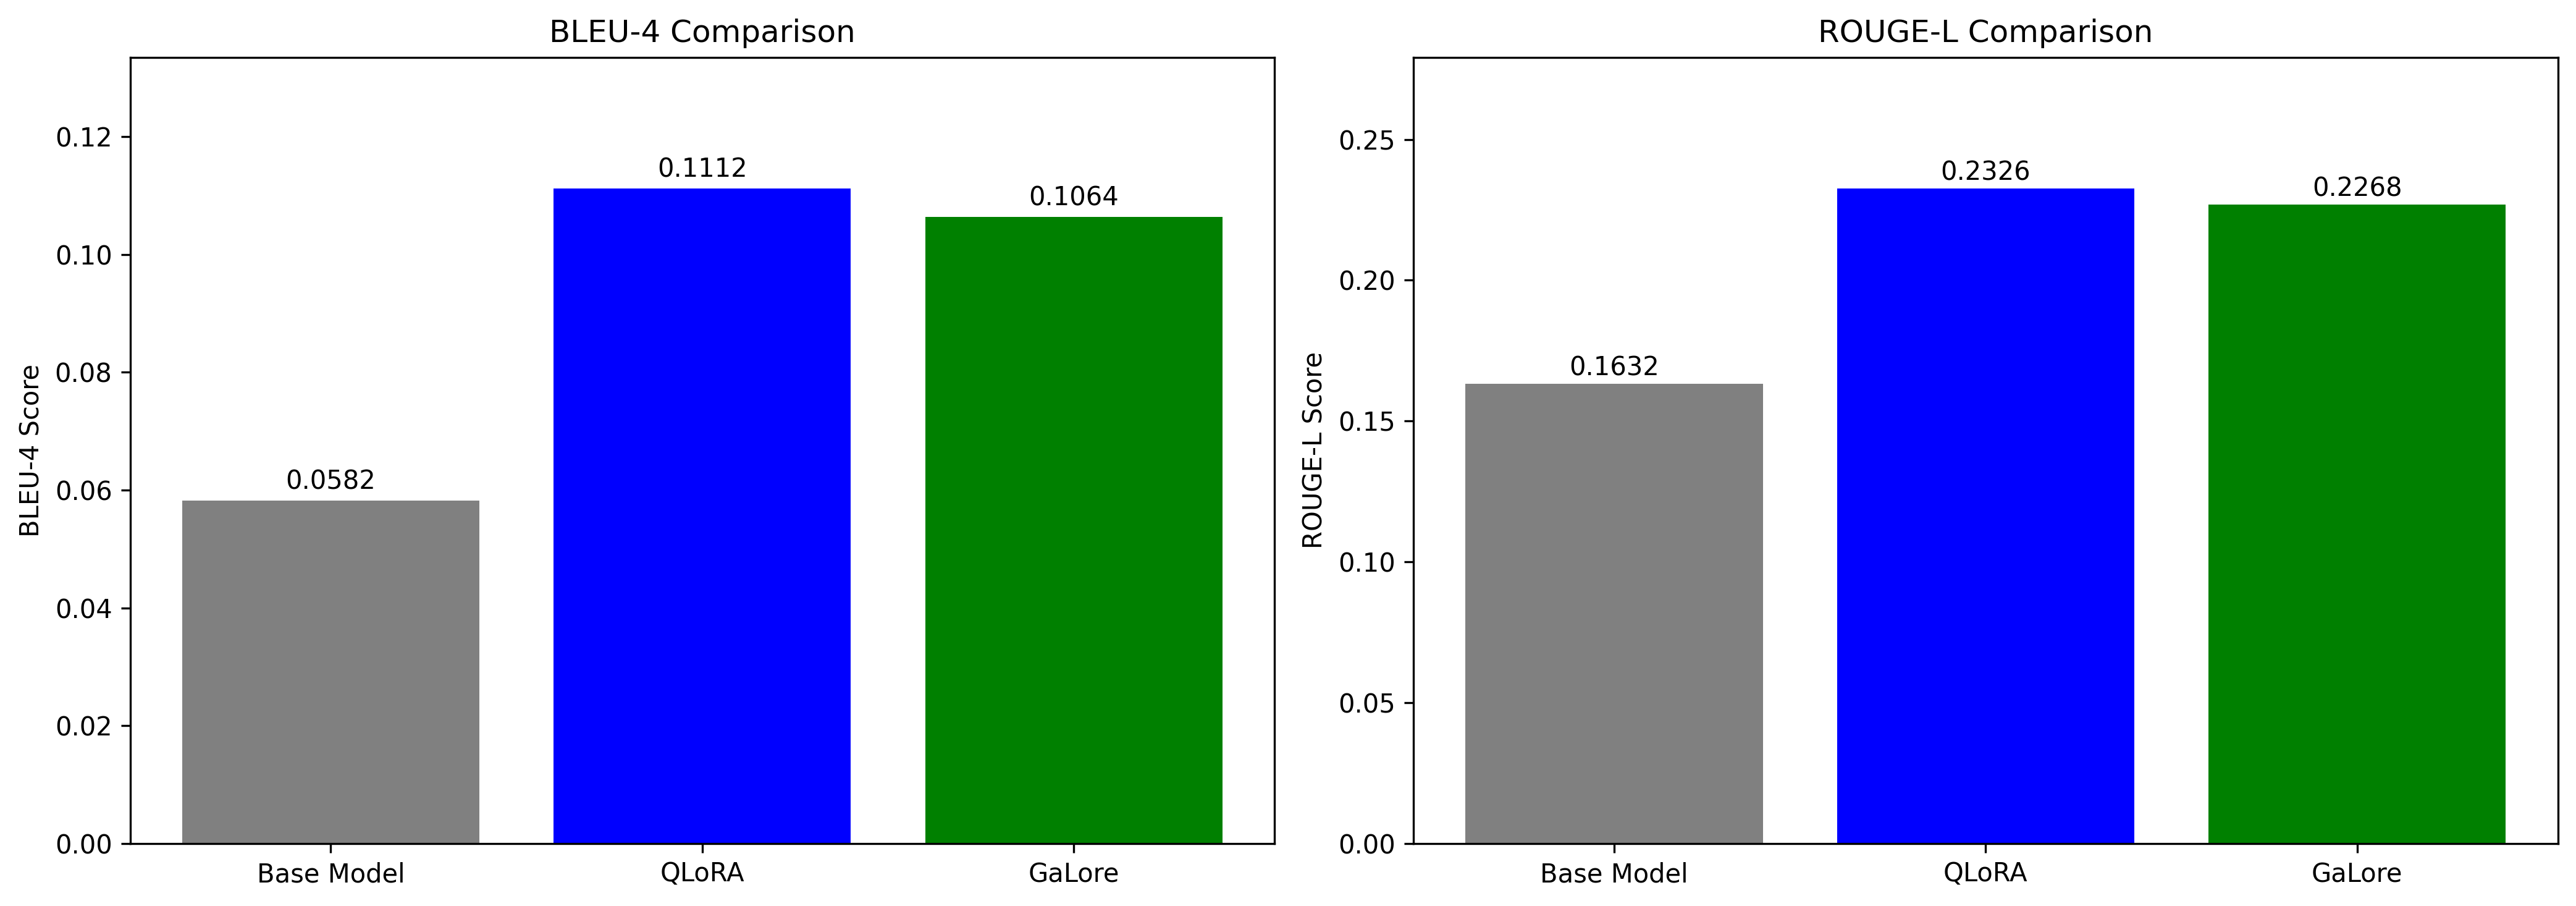

In [39]:
# BLEU/ROUGE comparison plot
visualizer.plot_bleu_rouge_comparison()

from IPython.display import Image, display
display(Image('results/plots/bleu_rouge_comparison.png'))

Memory vs Performance grafigi kaydedildi: ./results/plots/memory_vs_performance.png


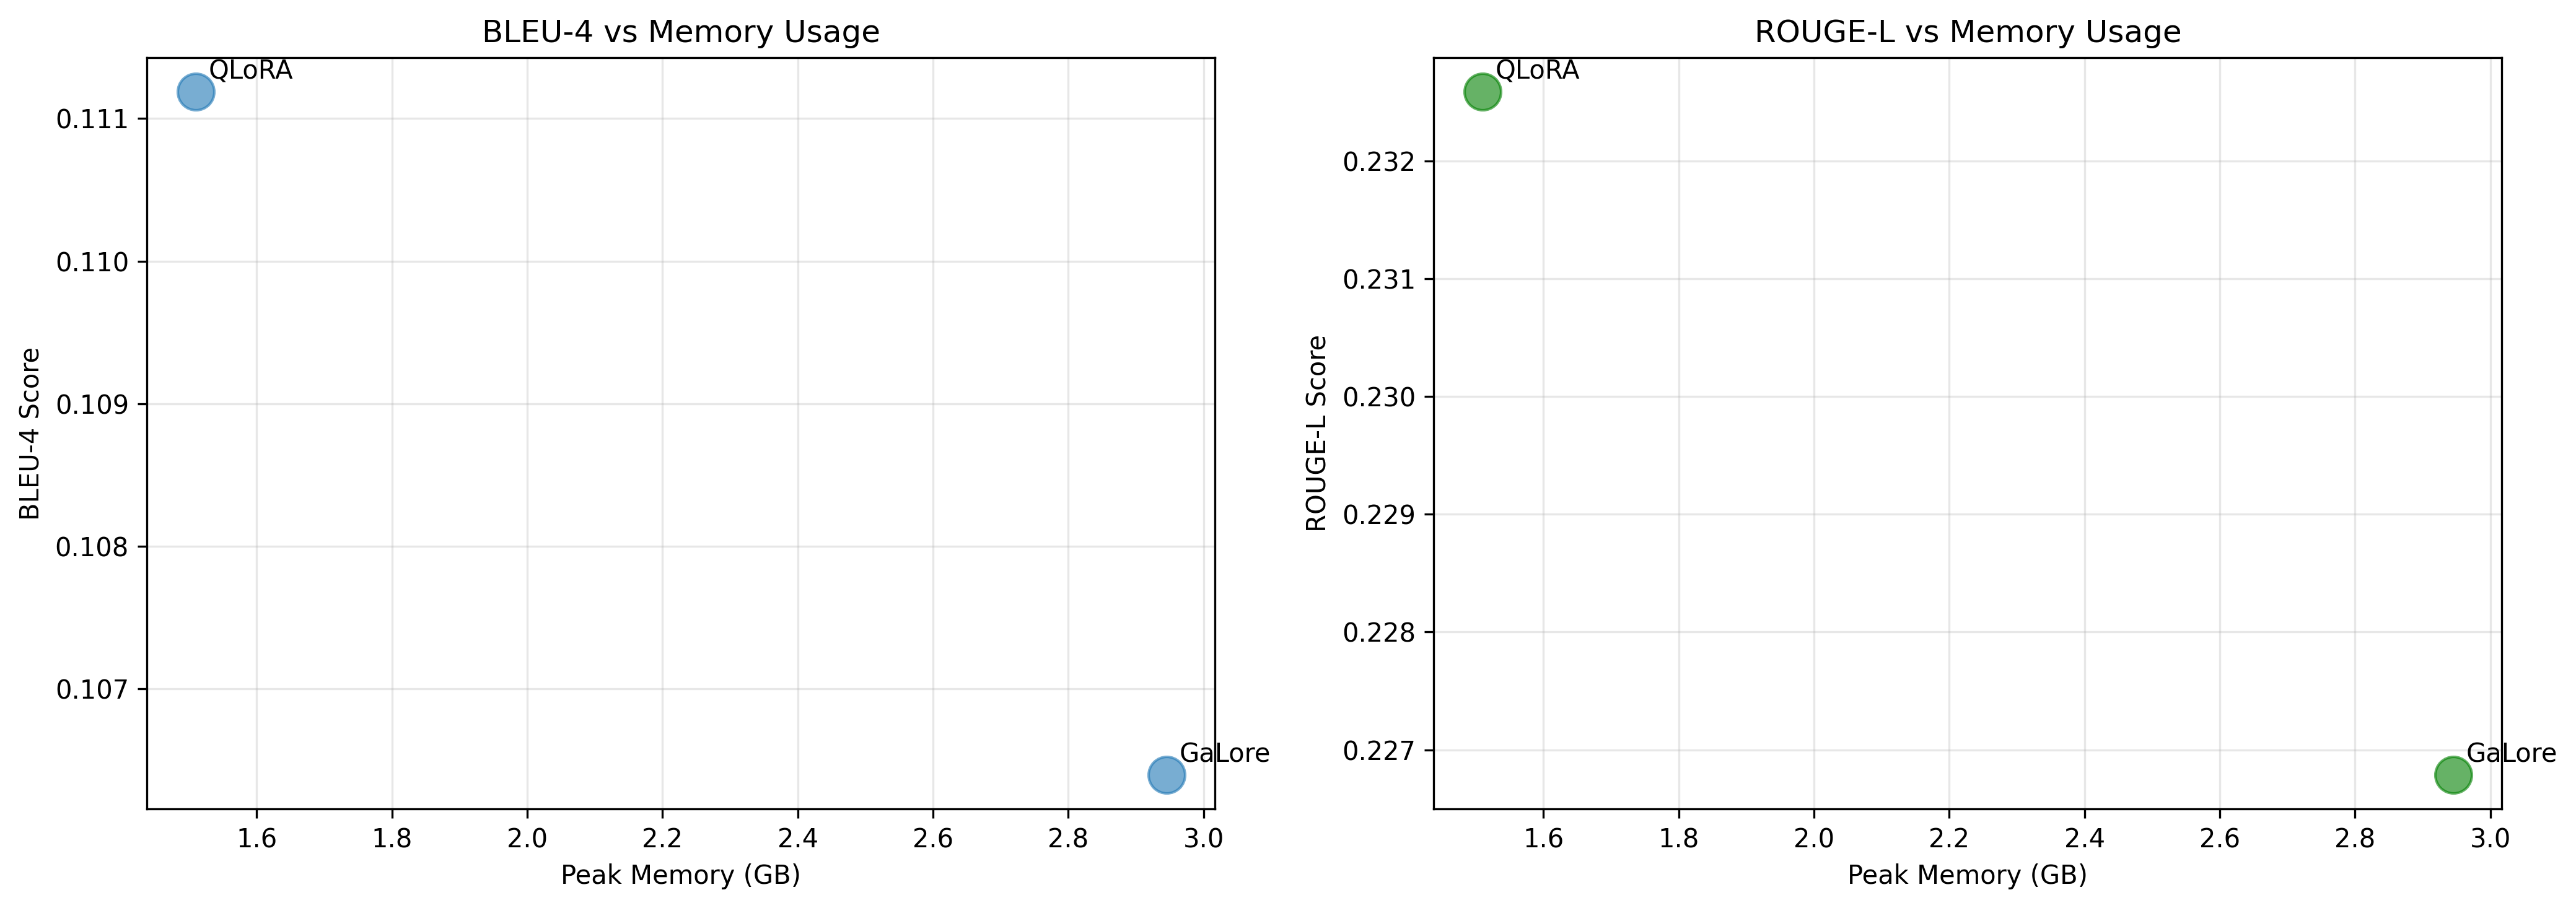

In [40]:
# Memory vs Performance plot
visualizer.plot_memory_vs_performance()

display(Image('results/plots/memory_vs_performance.png'))

In [41]:
# Summary report
visualizer.create_summary_report()

with open('results/summary_report.txt', 'r') as f:
    print(f.read())


FINE-TUNING COMPARISON SUMMARY REPORT

BASE MODEL PERFORMANCE:
  BLEU-4:  0.0582
  ROUGE-L: 0.1632

QLORA PERFORMANCE:
  BLEU-4:  0.1112
  ROUGE-L: 0.2326
  BLEU-4 Improvement:  +0.0530
  ROUGE-L Improvement: +0.0694
  Peak Memory: 1.51 GB
  Training Time: 2.08 hours

GALORE PERFORMANCE:
  BLEU-4:  0.1064
  ROUGE-L: 0.2268
  BLEU-4 Improvement:  +0.0482
  ROUGE-L Improvement: +0.0636
  Peak Memory: 2.95 GB
  Training Time: 1.40 hours


Summary report kaydedildi: ./results/summary_report.txt
FINE-TUNING COMPARISON SUMMARY REPORT

BASE MODEL PERFORMANCE:
  BLEU-4:  0.0582
  ROUGE-L: 0.1632

QLORA PERFORMANCE:
  BLEU-4:  0.1112
  ROUGE-L: 0.2326
  BLEU-4 Improvement:  +0.0530
  ROUGE-L Improvement: +0.0694
  Peak Memory: 1.51 GB
  Training Time: 2.08 hours

GALORE PERFORMANCE:
  BLEU-4:  0.1064
  ROUGE-L: 0.2268
  BLEU-4 Improvement:  +0.0482
  ROUGE-L Improvement: +0.0636
  Peak Memory: 2.95 GB
  Training Time: 1.40 hours



## 9. Side-by-Side Example Generations

In [42]:
with open('results/metrics/base_model_examples.json', 'r') as f:
    base_examples = json.load(f)

with open('results/metrics/qlora_examples.json', 'r') as f:
    qlora_examples = json.load(f)

with open('results/metrics/galore_examples.json', 'r') as f:
    galore_examples = json.load(f)

In [43]:
num_examples = min(10, len(base_examples))

for i in range(num_examples):
    print(f"EXAMPLE {i+1}")

    print(f"[INSTRUCTION]")
    print(base_examples[i]['instruction'])

    print(f"[EXPECTED RESPONSE]")
    print(base_examples[i]['expected'])

    print(f"[BASE MODEL]")
    print(base_examples[i]['generated'])

    print(f"[QLORA MODEL]")
    print(qlora_examples[i]['generated'])

    print(f"[GALORE MODEL]")
    print(galore_examples[i]['generated'])



EXAMPLE 1
[INSTRUCTION]
Can you tell me if there is any information on how much the recently fallen rock on El Capitan weighed?
[EXPECTED RESPONSE]
There was no immediate estimate for how much the rock that fell in the most recent incident weighed, but park officials said that all of the rock falls that took place on Wednesday weighed a total of 1,300 tons (1,100 metric tons).
[BASE MODEL]
user
Can you tell me if there is any information on how much the recently fallen rock on El Capitan weighed?
model
Okay, let's dive into the fascinating and somewhat mysterious weight of El Capitan's fallen rock! It's a surprisingly complex and debated topic. Here's a breakdown of what we know, based on recent research and analysis:

**The Initial Estimates (and Why They Were So Large):**

* **Early Estimates (1990s):** In the 1990s, estimates ranged from 200 to 500 tons. This was largely based on the size of the rock fragments and the sheer volume of material that had fallen.
* **The "Giant" Theory 

## 10. Final Summary

In [44]:
print("1. DATASET:")
print(f"   - Train samples: {len(train_processed)}")
print(f"   - Test samples: {len(test_processed)}")
print(f"   - Sources: Alpaca, Tulu v2, Ultrachat")

print("2. BASE MODEL PERFORMANCE:")
print(f"   - BLEU-4: {base_results['bleu_4']:.4f}")
print(f"   - ROUGE-L: {base_results['rouge_l']:.4f}")

print("3. QLORA:")
print(f"   - BLEU-4: {qlora_eval_results['bleu_4']:.4f}")
print(f"   - ROUGE-L: {qlora_eval_results['rouge_l']:.4f}")
print(f"   - Peak Memory: {qlora_metrics['memory_stats']['peak_memory_allocated_gb']:.2f} GB")
print(f"   - Training Time: {qlora_metrics['training_time_hours']:.2f} hours")

print("4. GALORE:")
print(f"   - BLEU-4: {galore_eval_results['bleu_4']:.4f}")
print(f"   - ROUGE-L: {galore_eval_results['rouge_l']:.4f}")
print(f"   - Peak Memory: {galore_metrics['memory_stats']['peak_memory_allocated_gb']:.2f} GB")
print(f"   - Training Time: {galore_metrics['training_time_hours']:.2f} hours")

print("5. CIKTILAR:")
print("   - Comparison Table: results/metrics/comparison_table.csv")
print("   - Plots: results/plots/")
print("   - Examples: results/metrics/*_examples.json")
print("   - Summary: results/summary_report.txt")

1. DATASET:
   - Train samples: 15000
   - Test samples: 6000
   - Sources: Alpaca, Tulu v2, Ultrachat
2. BASE MODEL PERFORMANCE:
   - BLEU-4: 0.0582
   - ROUGE-L: 0.1632
3. QLORA:
   - BLEU-4: 0.1112
   - ROUGE-L: 0.2326
   - Peak Memory: 1.51 GB
   - Training Time: 2.08 hours
4. GALORE:
   - BLEU-4: 0.1064
   - ROUGE-L: 0.2268
   - Peak Memory: 2.95 GB
   - Training Time: 1.40 hours
5. CIKTILAR:
   - Comparison Table: results/metrics/comparison_table.csv
   - Plots: results/plots/
   - Examples: results/metrics/*_examples.json
   - Summary: results/summary_report.txt


In [45]:
print("Kaydedilen dosyalar:")
for root, dirs, files in os.walk('results/'):
    for file in files:
        filepath = os.path.join(root, file)
        print(f"  {filepath}")

Kaydedilen dosyalar:
  results/summary_report.txt
  results/examples/.gitkeep
  results/plots/bleu_rouge_comparison.png
  results/plots/.gitkeep
  results/plots/memory_vs_performance.png
  results/metrics/galore_examples.json
  results/metrics/galore_evaluation_results.json
  results/metrics/comparison_table.csv
  results/metrics/base_model_examples.json
  results/metrics/qlora_metrics.json
  results/metrics/hyperparameter_comparison.csv
  results/metrics/galore_metrics.json
  results/metrics/.gitkeep
  results/metrics/base_model_results.json
  results/metrics/qlora_examples.json
  results/metrics/qlora_evaluation_results.json
